# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Formação Cientista de Dados</font>


## Projeto 03 - Prevendo o Nível de Satisfação dos Clientes do Santander

Este notebook contém as seguintes fases para a análise dos modelos de Machine Learning
 - Pré-Processamento
 - Criação do Modelo de Machine Learning
 - Validação e Otimização do Modelo
 - Previsão e Relatorios

## Definição do Problema de Negócio

O Banco Santander gostaria de identificar clientes insatisfeitos no início do relacionamento. Isso irá permitir que o Santander adote medidas proativas para melhorar a felicidade de um cliente antes que seja tarde demais.

Dataset: https://www.kaggle.com/c/santander-customer-satisfaction/data

### Informações sobre os atributos:

O dataset possui um grande número de variáveis numéricas e anonimas. A coluna 'TARGET' é a variável preditora

0. Clientes Satisfeitos
1. Clientes Insatisfeitos

## Extraindo e Carregando os Dados

In [1]:
# Importando bibliotecas que serao utilizadas neste projeto
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler 

In [2]:
# Carregando arquivo csv usando Pandas
train = pd.read_csv("../data/train.csv", header = 0)

## Análise Exploratória de Dados

In [3]:
# Visualizando o shape do dataset (76.020 linhas x 371 colunas)
# Neste caso algoritmo pode apresentar problemas de performance devido a alta dimensionalidade.
print(train.shape)

# Visualizando as 20 primeiras linhas do dataset
train.head(20)

(76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.00,195.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
5,13,2,23,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87975.750000,0
6,14,2,27,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94956.660000,0
7,18,2,26,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,251638.950000,0
8,20,2,45,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101962.020000,0
9,23,2,25,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,356463.060000,0


In [4]:
# Tipo de dados de cada atributo
train.dtypes

ID                                 int64
var3                               int64
var15                              int64
imp_ent_var16_ult1               float64
imp_op_var39_comer_ult1          float64
imp_op_var39_comer_ult3          float64
imp_op_var40_comer_ult1          float64
imp_op_var40_comer_ult3          float64
imp_op_var40_efect_ult1          float64
imp_op_var40_efect_ult3          float64
imp_op_var40_ult1                float64
imp_op_var41_comer_ult1          float64
imp_op_var41_comer_ult3          float64
imp_op_var41_efect_ult1          float64
imp_op_var41_efect_ult3          float64
imp_op_var41_ult1                float64
imp_op_var39_efect_ult1          float64
imp_op_var39_efect_ult3          float64
imp_op_var39_ult1                float64
imp_sal_var16_ult1               float64
ind_var1_0                         int64
ind_var1                           int64
ind_var2_0                         int64
ind_var2                           int64
ind_var5_0      

In [5]:
# Sumário estatístico
train.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


,TARGET,%
0,73012,96.043147
1,3008,3.956853


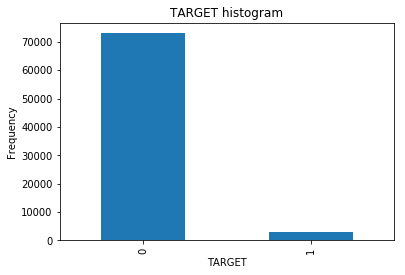

In [6]:
# Existe um problema de desbalanceamento de classes, ou seja, volume maior de um dos tipos de classe. 
# Podemos ver abaixo que existe uma clara desproporção (menos de 4% sao clientes insatisfeitos)
# entre as classes 0 (clientes satisfeitos) e 1 (clientes insatisfeitos).

# Visualizando a distribuição das classes (variavel TARGET)
pd.value_counts(train['TARGET']).plot.bar()
plt.title('TARGET histogram')
plt.xlabel('TARGET')
plt.ylabel('Frequency')

# Visualizando um df com quantidade e percentual da variavel TARGET
df = pd.DataFrame(train['TARGET'].value_counts())
df['%'] = 100*df['TARGET']/train.shape[0]
df


## Feature Selection - Método Ensemble

Bagged Decision Trees, como o algoritmo RandomForest (esses são chamados de Métodos Ensemble), podem ser usados para estimar a importância de cada atributo. Esse método retorna um score para cada atributo.
Quanto maior o score, maior a importância do atributo.

In [7]:
# Importância do Atributo com o Extra Trees Classifier

# Import dos Módulos
from sklearn.ensemble import ExtraTreesClassifier

# Separando o array em componentes de input e output
X = train.iloc[:,:-1]
Y = train.TARGET

# Criação do Modelo - Feature Selection
modelo = ExtraTreesClassifier()
modelo.fit(X, Y)

# Convertendo o resultado em um dataframe
df = pd.DataFrame(train.columns,columns=['Coluna'])
df['Importancia'] = pd.DataFrame(modelo.feature_importances_.astype(float))

# Realizando a ordenacao por Importancia (Maior para Menor)
result = df.sort_values('Importancia',ascending=False)

# Imprimindo as 30 variaveis mais importantes
cols_of_interest = result[1:30]['Coluna']
cols_of_interest = cols_of_interest.append(pd.Series(['TARGET']))
print(cols_of_interest)

# Deixando somente as colunas de interesse no df de treino
new_train = train[cols_of_interest]


369                       var38
2                         var15
332       saldo_medio_var5_ult3
330      saldo_medio_var5_hace3
327              num_var45_ult3
325             num_var45_hace3
324             num_var45_hace2
278              num_var22_ult3
326              num_var45_ult1
280          num_med_var45_ult3
329      saldo_medio_var5_hace2
276             num_var22_hace3
275             num_var22_hace2
331       saldo_medio_var5_ult1
191                 saldo_var42
64                    ind_var30
281         num_meses_var5_ult3
183                 saldo_var30
165                  saldo_var5
290    num_meses_var39_vig_ult3
194                       var36
277              num_var22_ult1
279          num_med_var22_ult3
25                     ind_var5
159                   num_var42
14      imp_op_var41_efect_ult3
12      imp_op_var41_comer_ult3
17      imp_op_var39_efect_ult3
131           num_op_var39_ult3
0                        TARGET
dtype: object


## Análise Exploratória de Dados após aplicar Feature Selection

In [8]:
# Verifica se existem valores nulos no novo dataset
new_train.isnull().values.any()

False

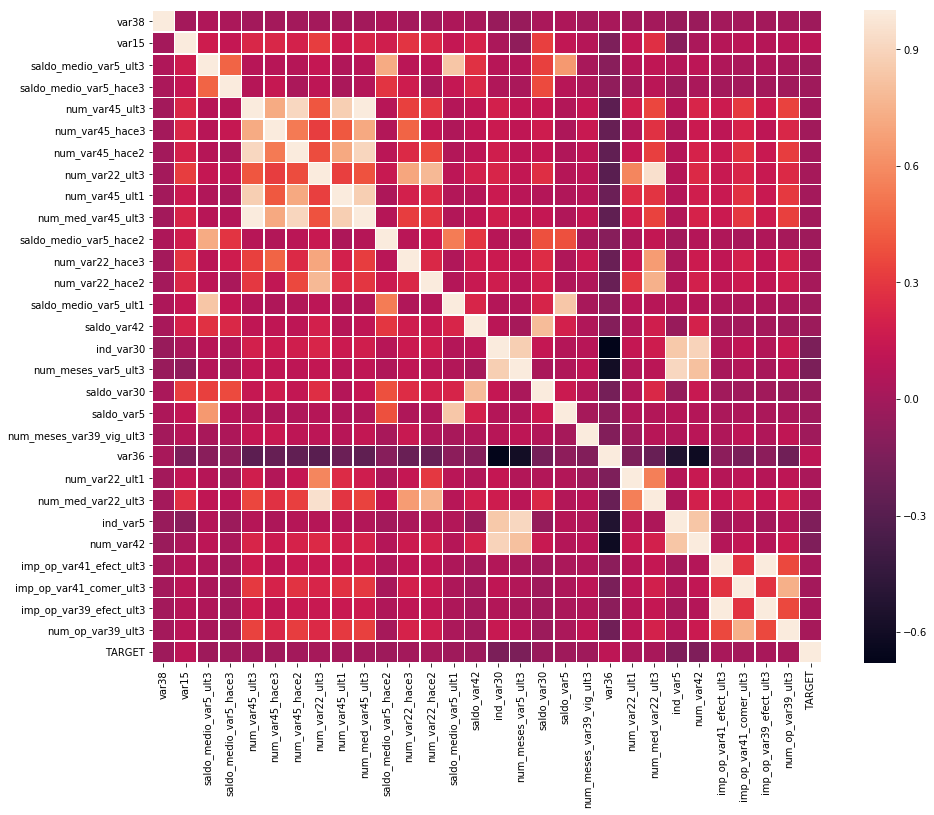

In [9]:
# Correlacoes
import seaborn as sns

# Aplicando a correlacao
cor_mat = new_train.corr()

# Visualizando o grafico de heatmap
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(cor_mat,linewidths=.5, ax=ax);


### Analise Exploratoria da variavel 'var38'

In [10]:
# Sumário estatístico
new_train.var38.describe()

count    7.602000e+04
mean     1.172358e+05
std      1.826646e+05
min      5.163750e+03
25%      6.787061e+04
50%      1.064092e+05
75%      1.187563e+05
max      2.203474e+07
Name: var38, dtype: float64

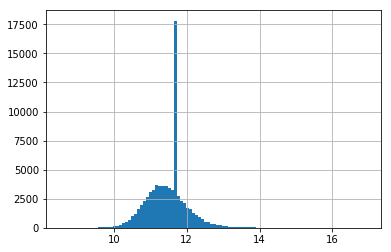

In [11]:
# Histograma da variavel 'var38' 
# Apresenta um valor recorrente muito diferente dos demais
new_train.var38.map(np.log).hist(bins=100);

In [12]:
# Visualizando o valor mais comum da variavel
# O valor 117310.979016 aparece 14.868 vezes (bem maior que os demais valores)
new_train.var38.value_counts()

117310.979016    14868
451931.220000       16
463625.160000       12
288997.440000       11
104563.800000       11
236690.340000        8
329603.970000        7
104644.410000        7
67088.310000         7
125722.440000        7
128318.520000        7
97639.560000         6
100466.730000        6
70813.800000         6
163432.470000        6
168733.620000        6
105260.880000        6
185385.690000        6
85814.040000         5
235476.720000        5
121603.020000        5
93037.680000         5
63820.890000         5
33184.020000         5
126065.040000        5
71302.530000         5
208961.790000        5
171932.700000        5
131353.470000        5
127141.500000        5
                 ...  
59680.710000         1
46170.180000         1
75729.810000         1
92730.750000         1
98087.700000         1
31312.410000         1
151944.720000        1
49222.200000         1
46682.640000         1
79753.740000         1
217717.530000        1
156462.240000        1
140446.5900

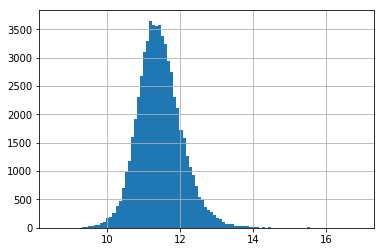

In [13]:
# Visualizando o histograma removendo o valor que mais aparece
new_train.loc[~np.isclose(new_train.var38, 117310.979016), 'var38'].map(np.log).hist(bins=100);

### Analise Exploratoria da variavel 'var15'

In [14]:
# Sumário estatístico
new_train.var15.describe()

count    76020.000000
mean        33.212865
std         12.956486
min          5.000000
25%         23.000000
50%         28.000000
75%         40.000000
max        105.000000
Name: var15, dtype: float64

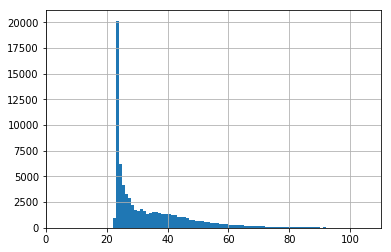

In [15]:
# Histograma da variavel 'var15' 
# Apresenta um valor recorrente muito diferente dos demais
# De acordo com as informacoes da variavel e em pesquisas dentro do Kaggle, parece ser a idade do cliente
new_train['var15'].hist(bins=100);

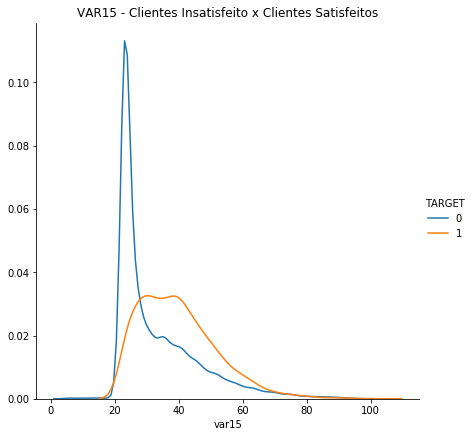

In [16]:
# Com esse grafico de densidade percebe-se que os clientes insatisfeitos tem idade maior
sns.FacetGrid(new_train, hue="TARGET", height=6) \
   .map(sns.kdeplot, "var15") \
   .add_legend()
plt.title('VAR15 - Clientes Insatisfeito x Clientes Satisfeitos');

### Analise Exploratoria da variavel 'var36'

In [17]:
# Sumário estatístico
new_train.var36.describe()

count    76020.000000
mean        40.449079
std         47.362719
min          0.000000
25%          2.000000
50%          3.000000
75%         99.000000
max         99.000000
Name: var36, dtype: float64

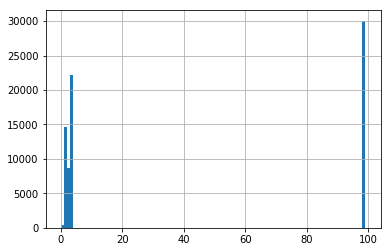

In [18]:
# Histograma da variavel 'var36' 
# 75% dos dados tem o valor 99
# Os demais estao distribuidos entre 0, 1, 2 e 3
new_train['var36'].hist(bins=100);

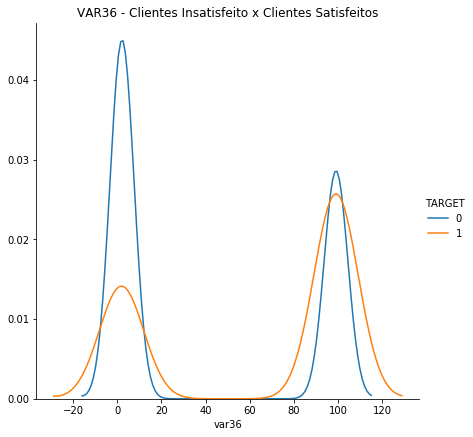

In [19]:
# Com esse grafico de densidade percebe-se que se o valor da variavel for entre 0,1,2 e 3, 
# a variacao de clientes insatisfeitos eh muito maior quando a variavel var36 tem o valor de 99
sns.FacetGrid(new_train, hue="TARGET", height=6) \
   .map(sns.kdeplot, "var36") \
   .add_legend()
plt.title('VAR36 - Clientes Insatisfeito x Clientes Satisfeitos');

## Feature Engineering

Resolvendo o problema de Overfitting da variavel TARGET utilizando o OverSampling ou Resample

In [20]:
# Resolvendo problema de Overfitting utilizando o OverSampling

# Import dos módulos
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Separando o array em componentes de input e output
X = new_train.iloc[:,:-1]
Y = new_train.TARGET

# Aplicando a funcao SMOTE
# SMOTE eh um metodo de oversampling. Ele cria exemplos sinteticos da classe minoritaria ao inves de criar copias
sm = SMOTE(random_state=0)
X_treino_res, Y_treino_res = sm.fit_sample(X, Y)

np.bincount(Y_treino_res)

array([73012, 73012])

,TARGET,%
1,73012,50.0
0,73012,50.0


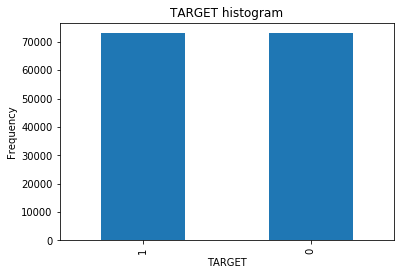

In [21]:
# Distribuição das classes (variavel TARGET) apos aplicar OverSampling
pd.value_counts(Y_treino_res).plot.bar()
plt.title('TARGET histogram')
plt.xlabel('TARGET')
plt.ylabel('Frequency')

# Visualizando um df com quantidade e percentual da variavel TARGET
df = pd.DataFrame(pd.value_counts(Y_treino_res), columns=['TARGET'])
df['%'] = 100*df['TARGET']/Y_treino_res.shape[0]
df

## Criação e Validação dos Modelos de Machine Learning

LR: 0.681868 (0.029189)
RF: 0.958507 (0.019685)
LDA: 0.675821 (0.021550)
KNN: 0.874932 (0.009974)
CART: 0.946845 (0.030969)


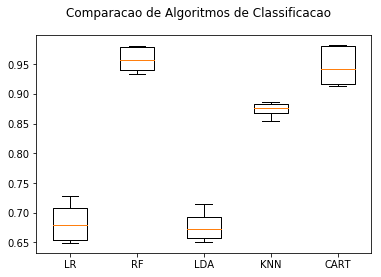

In [22]:
# Criacao dos modelos de Classificacao

# Import dos módulos
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

warnings.filterwarnings("ignore")

# Separando o array em componentes de input e output (dados com oversampling)
X = X_treino_res
Y = Y_treino_res

# Aplicando a mesma escala nos dados
X = MinMaxScaler().fit_transform(X)

# Padronizando os dados (0 para a média, 1 para o desvio padrão)
X = StandardScaler().fit_transform(X)

# Definindo os valores para o número de folds
num_folds = 10
seed = 10

# Preparando a lista de modelos
modelos = []
modelos.append(('LR', LogisticRegression()))
modelos.append(('RF', RandomForestClassifier()))
modelos.append(('LDA', LinearDiscriminantAnalysis()))
modelos.append(('KNN', KNeighborsClassifier()))
modelos.append(('CART', DecisionTreeClassifier()))
#modelos.append(('SVM', SVC())) # comentei este modelo pois demora bastante e nao eh melhor que o Random Forest

# Avaliando cada modelo em um loop
resultados = []
nomes = []

for nome, modelo in modelos:
    kfold = KFold(n_splits = num_folds, random_state = seed)
    cv_results = cross_val_score(modelo, X, Y, cv = kfold, scoring = 'accuracy')
    resultados.append(cv_results)
    nomes.append(nome)
    msg = "%s: %f (%f)" % (nome, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot para comparar os algoritmos
fig = plt.figure()
fig.suptitle('Comparacao de Algoritmos de Classificacao')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes)
plt.show()

# Otimizando Performance com Métodos Ensemble

## Algoritmo XGBoost - Extreme Gradient Boosting

In [23]:
# Import dos módulos
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier

# Separando o array em componentes de input e output (dados com oversampling)
X = X_treino_res
Y = Y_treino_res

# Aplicando a mesma escala nos dados
X = MinMaxScaler().fit_transform(X)

# Definindo o tamanho dos dados de treino e de teste
teste_size = 0.3
seed = 10

# Criando o dataset de treino e de teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, Y, test_size = teste_size, random_state = seed)

# Criando o modelo
modeloXGB = XGBClassifier()

# Treinando o modelo
modeloXGB.fit(X_treino, y_treino)

# Fazendo previsões
y_pred = modeloXGB.predict(X_teste)
previsoes = [round(value) for value in y_pred]

# Avaliando as previsões
accuracy = accuracy_score(y_teste, previsoes)
print("Acurácia: %.2f%%" % (accuracy * 100.0))

Acurácia: 92.13%


# Realizando Previsões

## Utilizando o modelo com maior performance (Random Forest) para fazer previsoes

In [24]:
# Fazendo previsões com o Modelo Random Forest

# Import dos módulos
from sklearn.ensemble import RandomForestClassifier

# Separando o array em componentes de input e output
X = X_treino_res
Y = Y_treino_res

# Aplicando a mesma escala nos dados
X = MinMaxScaler().fit_transform(X)

# Padronizando os dados (0 para a média, 1 para o desvio padrão)
X = StandardScaler().fit_transform(X)

# Definindo o tamanho dos dados de treino e de teste
teste_size = 0.3
seed = 10

# Criando o dataset de treino e de teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, Y, test_size = teste_size, random_state = seed)

# Criação do modelo
modeloRF = RandomForestClassifier(n_estimators = 100)
modeloRF.fit(X_treino, y_treino)

# Fazendo previsões
y_pred = modeloRF.predict(X_teste)
previsoes = [round(value) for value in y_pred]

# Avaliando as previsões
accuracy = accuracy_score(y_teste, previsoes)
print("Acurácia: %.2f%%" % (accuracy * 100.0))


Acurácia: 96.17%


In [25]:
# Relatório de Classificação

# Import dos módulos
from sklearn.metrics import classification_report

# Fazendo as previsões e construindo o relatório
report = classification_report(y_teste, previsoes)

# Imprimindo o relatório
print(report)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     21832
           1       0.97      0.96      0.96     21976

   micro avg       0.96      0.96      0.96     43808
   macro avg       0.96      0.96      0.96     43808
weighted avg       0.96      0.96      0.96     43808



In [26]:
# Confusion Matrix
# Permite verificar a acurácia em um formato de tabela
matrix = confusion_matrix(y_teste, previsoes)
print("Confusion Matrix")
print(matrix)

Confusion Matrix
[[21104   728]
 [  950 21026]]


In [27]:
# Criacao de função para criar um plot para a confusion matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):



    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

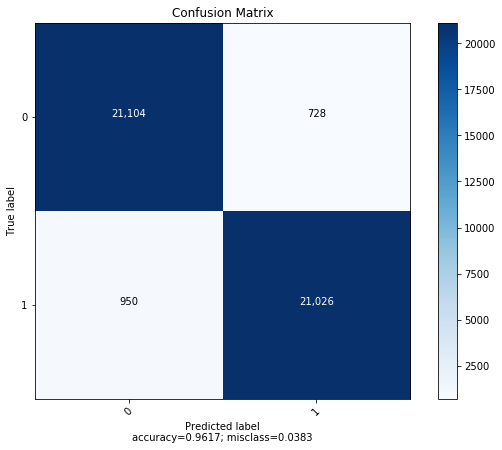

In [28]:
# Chamando a função para visualizar a confusion matrix
plot_confusion_matrix(matrix, 
                      normalize    = False,
                      target_names = ['0', '1'],
                      title        = "Confusion Matrix")